# Calculate Information Accretion (IA) of GO Terms

**Information accretion** refers to the process of accumulating functional information as you traverse from child nodes to parent nodes in the GO hierarchy. Since the GO graph is a directed acyclic graph (DAG), each child node represents a more specific biological concept than its parent, and information accretes (or builds up) as you move upwards in the hierarchy, aggregating details about the biological processes, cellular components, or molecular functions.


## Setup and Imports

In [2]:
# Standard library imports
import math
import os
import pickle
import random
import re
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pygraphviz as pgv
import requests
from tqdm.auto import tqdm

# Machine learning and data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import hdbscan

# Bioinformatics and deep learning
from obonet import read_obo
import networkx as nx
from goatools.obo_parser import GODag
import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, HeteroData
from transformers import BertTokenizer, BertModel

# Configuration
pd.options.mode.copy_on_write = True

# Matplotlib settings
plt.rc("axes", grid=False)
plt.rc("xtick.major", size=5)
plt.rc("ytick.major", size=5)

# Define folder paths
base_dir = Path(os.getcwd())
print(f"Base directory: {base_dir}")

# Load GO DAG
go_graph = read_obo(base_dir / "data/go/go-basic.obo")
print(go_graph)

Base directory: /home/clever/projects/aid2go
MultiDiGraph named 'go' with 40939 nodes and 79313 edges


## Convenience Functions

### Plot GO Hierarch

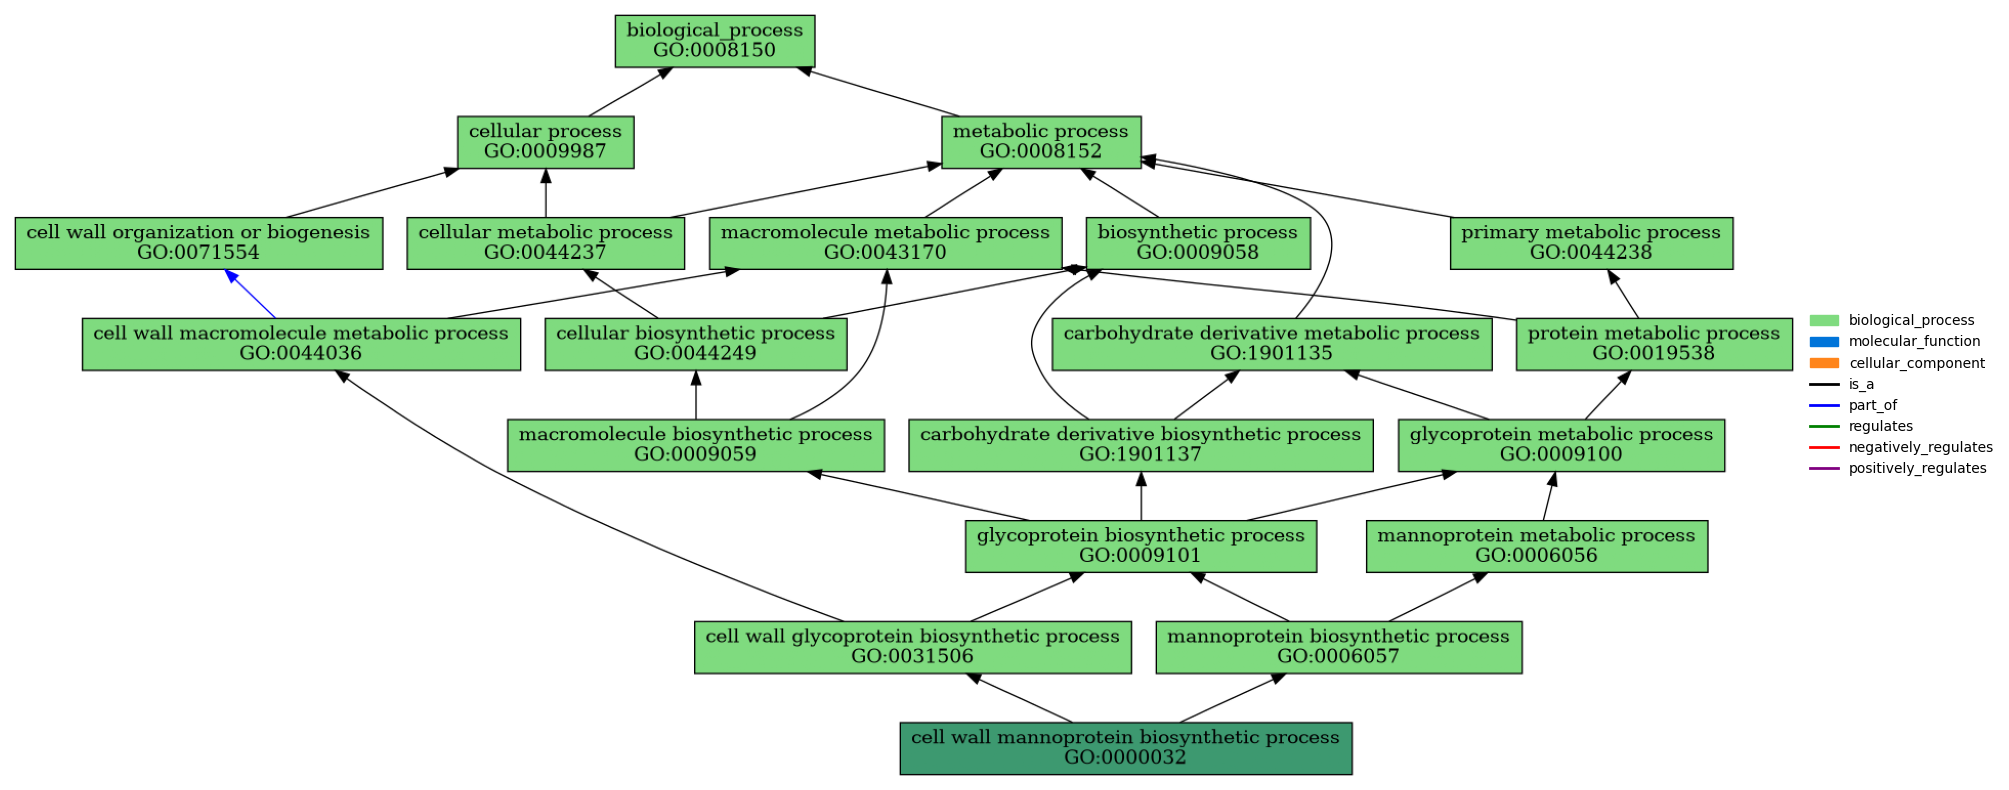

In [4]:
from aid2go.aid_go import plot_go_term

plot_go_term(go_graph, "GO:0000032", include="both")

In [ ]:
for node, attr in go_graph.nodes(data=True):
    print(node, attr)

In [ ]:
[(node, attr) for node, attr in go_graph.nodes(data=True) if node == "GO:0035639"]

## Information Content (IC)

**Information Content (IC)** is a measure of how much information a term carries. A term that is very specific (e.g., a rare function) carries more information than a more general term (e.g., a common function).

$$
IC(T) = -\log_2(\text{Pr}(T))
$$

Where $Pr(T)$ is the probability of observing the term $T$. The IC for a subgraph is the sum of the IC values for each node in the subgraph. Considering the ontology terms:

$$
IC(term) = -\log(p(term))
$$

Where $p(term)$ is the probability of encountering the $term$, calculated as the frequency of annotations to that term and its descendants divided by the total number of annotations. The more frequently a term is used, the lower its IC, meaning general terms have low IC, while specific terms have high IC.


In [ ]:
def compute_ia(go_term, go_graph, go_ic, accumulation_method="max"):
    """
    Calculates the Information Accretion (IA) for a given GO term
    by accumulating IC along paths to the root.
    """
    # Start with the IC of the current term
    ic_accumulated = go_ic.get(go_term, 0)

    # Get parent terms
    parent_terms = list(go_graph.predecessors(go_term))

    if not parent_terms:
        return ic_accumulated

    # Accumulate IC from parents
    if accumulation_method == "max":
        # Max IC from parent terms
        ic_accumulated += max(
            compute_ia(parent, go_graph, go_ic) for parent in parent_terms
        )
    elif accumulation_method == "average":
        # Average IC from parent terms
        parent_ic = [co(parent, go_graph, go_ic) for parent in parent_terms]
        ic_accumulated += sum(parent_ic) / len(parent_ic)

    return ic_accumulated

In [ ]:
# Step 1: Count occurrences of each GO term in the dataset
goterm_counts = associations_df["go_id"].value_counts()

# Step 2: Calculate total number of annotations
total_annotations = goterm_counts.sum()


# Step 3: Compute Information Content (IC) for each term
def compute_ic(term_count, total):
    probability = term_count / total
    return -math.log(probability) if probability > 0 else 0


# Step 4: Apply IC calculation to each GO term
go_ic = goterm_counts.apply(lambda count: compute_ic(count, total_annotations))

# Calculate IA for a specific GO term
go_term = "GO:0000001"  # Example GO term
ia_value = calculate_ia(go_term, go_graph, go_ic, "average")
print(f"Information Accretion (IA) for {go_term}: {ia_value}")

In [ ]:
# Calculate IA for all GO terms

ia_dict = {}

for go_term in tqdm(
    go_graph.nodes(), total=len(go_graph.nodes()), desc="Calculating IA..."
):
    ia_dict[go_term] = calculate_ia(go_term, go_graph, go_ic, "average")


ia_df = pd.DataFrame.from_dict(ia_dict, columns=["ia"], orient="index")
ia_df.reset_index(drop=False, inplace=True)
ia_df.rename(columns={"index": "go_id"}, inplace=True)
ia_df.describe()

## Load Protein Sequences for Training

In [ ]:
filepath = data_dir / "cafa/train_sequences.fasta"
train_dict = {}  # Dictionary to store protein sequences
for seq_record in SeqIO.parse(filepath, "fasta"):
    train_dict[seq_record.id] = str(seq_record.seq)

# Get the average sequence length
values = train_dict.values()

lengths = [len(value) for value in values]

if lengths:
    average_length = sum(lengths) / len(lengths)
else:
    average_length = 0

print(f"Length of sequences dictionary: {len(train_dict)}")
print(f"Average sequence lenght: {average_length:.2f}")

## Load Protein Sequences for Testing

In [ ]:
filepath = data_dir / "cafa/test_sequences.fasta"
test_dict = {}  # Dictionary to store protein sequences
for seq_record in SeqIO.parse(filepath, "fasta"):
    test_dict[seq_record.id] = str(seq_record.seq)

# Get the average sequence length
values = test_dict.values()

lengths = [len(value) for value in values]

if lengths:
    average_length = sum(lengths) / len(lengths)
else:
    average_length = 0

print(f"Length of sequences dictionary: {len(test_dict)}")
print(f"Average sequence lenght: {average_length:.2f}")

## Split Examples with Limited Knowledge and No Knowledge

Here, we consider that the training and testing datasets were created wisely, where overlapping sequences are partially annotated (i.e. this is the reason they are in both datasets) and non-overlapping sequences in the testing set are missing all annotations (i.e., they are new proteins).

### Check Overlapping Training vs Testing Sequences


In [ ]:
# Get protein ids
train_ids = list(train_dict.keys())
test_ids = list(test_dict.keys())

# Split ids between lk and nk
test_lk_ids = set(train_ids) & set(test_ids)  # limited knowledge, present in both sets
test_nk_ids = set(test_ids) - set(test_lk_ids)  # no knowledge, present only in test set

print(f"Number of proteins with limited knowledge: {len(test_lk_ids)}")
print(f"Number of proteins with no knowledge: {len(test_nk_ids)}")
print("\nSome protein ids with limited knowledge:")
print(list(test_lk_ids)[:10])
print("\nSome protein ids with no knowledge:")
print(list(test_nk_ids)[:10])

### Split Proteins by Knowledge Status

In [ ]:
# Split test dictionary
test_lk_dict = {k: train_dict[k] for k in test_lk_ids}
test_nk_dict = {k: test_dict[k] for k in test_nk_ids}

# Assert number of sequences
assert len(test_lk_ids) + len(test_nk_ids) == len(test_dict), "Length mismatch"
assert len(test_lk_ids) + len(test_nk_ids) == len(test_lk_dict) + len(
    test_nk_dict
), "Length mismatch"

print(f"Length of Limited Knowledge dictionary: {len(test_lk_ids)}")
print(f"Length of No Knowledge dictionary: {len(test_nk_dict)}")
print(f"Total number of sequences: {len(test_lk_ids) + len(test_nk_ids)}")